# Projet 6 : Détecter des faux-billets
Pierre-Eloi Ragetly

<a id=ToC></a>
## Table des matières
- [Import des librairies](#import)
- [Customisation des graphiques](#seaborn)
- [1. Pre-processing](#section1)
    - [1.1. Import des données](#import_data)
    - [1.2. Inventaire des données disponibles](#data_inventory)
    - [1.3. Analyse des doublons](#duplicates)
    - [1.4. Format des données](#DataFormat)
    - [1.5. Standardisation des données](#standard)
- [2. Description statistique des données](#section2)
    - [2.1. Visualisation de la variable is_genuine](#var_qual)
    - [2.2. Visualisations des variables quantitatives](#var_quan)
    - [2.3. ANOVA entre les variables quantitatives et la variable is_genuine](#ANOVA)
        - [2.3.1. Visualisation des variables quantitatives en fonction de is_genuine à l'aide de boîtes à moustaches](#anova_visu)
        - [2.3.2. Test d'analyse de la variance](#anova_test)
    - [2.4. Analyse des corrélations](#correl)
- [3. Analyse exploratoire de données](#section3)
    - [3.1. Réalisation d'une ACP](#ACP)
        - [3.1.1. Analyse de l'éboulis des valeurs propres](#eboulis)
        - [3.1.2. Représentation des variables par le cercle des corrélations](#cercle_correl)
        - [3.1.3. Représentation des individus par les plans factoriels](#plans_fact)
        - [3.1.4. Qualité de représentation des individus](#cos2)
        - [3.1.5. Contribution des individus aux axes](#CTR)
    - [3.2. Classification via la méthode du k-means](#kmeans)
        - [3.2.1. Application du k-means](#kmeans_app)
        - [3.2.2. Visualisation des groupes](#kmeans_vis)
- [4. Modélisation](#section4)
    - [4.1. Échantillonnage](#sampling)
    - [4.2. Régression Logistique](#logistic_reg)
        - [4.2.1. Régression logistique sans régularisation](#lr_withought)
        - [4.2.2. Régression logistique avec régularisation](#cross_validation)
    - [4.3. SVM](#SVM)
- [5. Tests](#section5)

<a id=import></a>
## Import des librairies

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, cluster, metrics, model_selection, linear_model, svm
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from functions import *
from IPython.display import display

<a id=seaborn></a>
## Customisation des graphiques

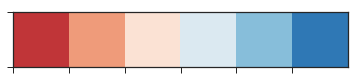

In [2]:
palette = sns.color_palette('RdBu')
sns.set(style='ticks', palette=palette, font_scale=1.4)
sns.palplot(palette)

<a id=section1></a>
## 1. Pre-processing

<a id=import_data></a>
### 1.1. Import des données

In [3]:
data = pd.read_csv("billets.csv")
data.head(3)

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84


<a id=data_inventory></a>
### 1.2 Inventaire des données disponibles

La PJ nous indique que le jeu de données contient les caractéristiques géométriques des billets de banque, avec :
- is_genuine : si le billet est un vrai ou pas
- length : la longueur du billet (en mm)
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
- margin_low : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- margin_up : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- diagonal : la diagonale du billet (en mm)

Nous avons donc une variable qualitative &ndash; *is_genuine* &ndash; et six quantitatives &ndash; les autres.
Commencons par vérifier la quantité de données disponibles.

In [4]:
r = data.shape[0]
c = data.shape[1]
print("La table comporte {} lignes et {} colonnes".format(r, c))

La table comporte 170 lignes et 7 colonnes


La table contient 170 individus et sept variables, i.e. l'intégralité des variables indiquées par la PJ. Nous vérifierons la présence de doublons plus tard &ndash; l'absence d'identifiant unique va compliquer un peu la tâche.

D'après le descriptif des données fourni par la PJ, toutes les caractéristiques géométriques sont en **mm**. Il va donc falloir vérifier les points suivants :
1. L'absence de données manquantes ;
2. La cohérence des données (les valeurs sont elles réalistes pour des dimensions de billets en mm) ;
3. l'homogénéité des données (Si toutes les données sont en mm on s'attend à avoir des extremums relativement proches et donc des écarts types faibles).

Pour se faire, la méthode `describe()` de Pandas sera utilisée. Cette méthode permet d'afficher les indicateurs statistiques les plus courants, une attention particulière sera portée aux indicateurs suivants :
- count (donne le nombre de valeurs renseignées)
- min
- max
- std (écart-type)

In [5]:
data.describe()

,length,height_left,height_right,margin_low,margin_up,diagonal
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


On peut voir que toutes les variables quantitatives comportent 170 valeurs renseignées, i.e. le nombre total d'individus. Il n'y a donc pas de données manquantes pour ces données.  
La vérification de données manquantes pour la variable qualitative **is_genuine** sera effectuée lors de l'analyse de cette dernière. **Étant donné  que c'est la variable clé sur laquelle notre modèle sera entrainé et testé, tout individu n'ayant pas de valeur pour cette variable sera supprimée.**

Les estimateurs min et max nous permettent de constater que les données sont bien toutes en **mm**, ce qui est conforté par les faibles écarts types observés.

<a id=duplicates></a>
### 1.3 Analyse des doublons

Vu qu'il n'y a pas d'identifiant unique, on va en créer un. Pour celà on va créer une clé qui sera égale aux valeurs concaténées (préalablement transformées en chaîne de caractères) de toutes les variables quantitatives. Puis on comptera le nombre de clés différentes et comparerons ce nombre à 170 pour connaître le nombre de doublons.

In [6]:
# On stocke toutes les données des variables quantitatives dans une matrice
# de format string
a_key = data.iloc[:, 1:].applymap(str).values

# On crée un vecteur qui va concaténer par ligne les valeurs de la matrice
# créée précédemment
Key = np.sum(a_key, axis=1)

# On compte le nombre de doublons en déduisant de 170 le nombre de clés uniques
n= np.unique(Key).size
print("Il y a {} doublons".format(170- n))

Il y a 0 doublons


On constate que les données ne contiennent pas de doublons.

<a id="DataFormat"></a>
### 1.4 Format des données

Comme dit précédemment, notre jeu comporte une variable qualitative et six quantitatives, on s'attend donc à avoir :

- un booléen pour la variables *is_genuine*
- des valeurs numériques pour les autres variables

On va vérifier le type de chaque variable pour s'en assurer.

In [7]:
data.dtypes

is_genuine         bool
length          float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
diagonal        float64
dtype: object

On a bien les formats de données attendus.

<a id=standard></a>
### 1.5 Standardisation des données

Les variables quantitatives renseignent sur les caractéristiques géométriques des billets, elles sont positives et donc non centrées (moyenne différente de 0). Il va falloir les normaliser pour pouvoir ensuite effectuer une Analyse en Composantes Principales (ACP). Pour se faire, nous utiliserons la méthode *StandardScaler()* de **Scikitlearn** qui effectue l'opération suivante :

$$x_{new}=\frac{x_{old}-\mu}{\sigma}$$

In [8]:
# On stocke les données dans un objet array
X = data.iloc[:, 1:].values

# On applique la méthode de standardisation
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

[Retourner à la table des matières](#ToC)

<a id=section2></a>
## 2. Description statistique des données

<a id=var_qual></a>
### 2.1. Visualisation de la variable **is_genuine**

La variable **is_genuine** étant une variable qualitative nous allons l'afficher sous la forme d'une table qui comportera l'effectif et la fréquence de chaque valeur prise par la variable.

In [9]:
name = data.columns[0]
display_qual_var(data, name)

,is_genuine,n,f (%)
0,True,100,58.8
1,False,70,41.2


On constate que la base de données comporte un nombre important de faux billets.  
Les fréquences calculées seront utilisées lors de la création d'échantillons pour la modélisation.

<a id=var_quan></a>
### 2.2. Visualisations des variables quantitatives

Pour la visualisation des variables qualitatives nous utiliserons des histogrammes

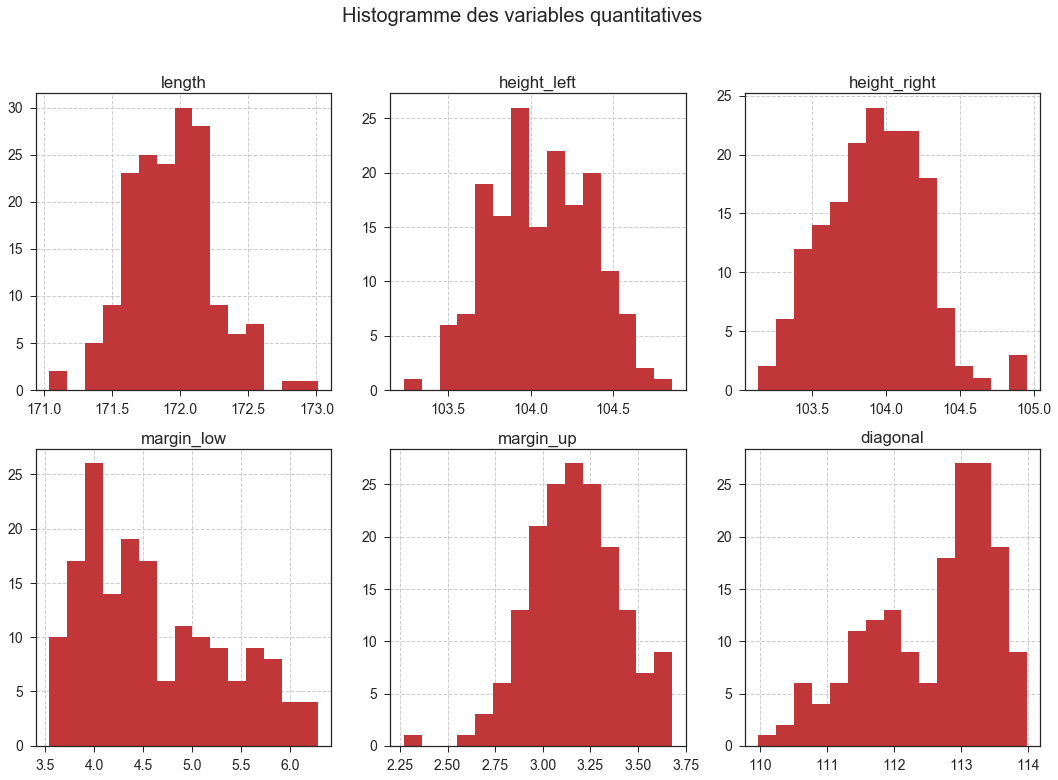

In [10]:
var = data.columns[1:]
display_hist(data, var, 15) 

Les histogrammes confirment la faible dipersion des données, on remarque de plus que la forme des distributions diffère d'une variable à l'autre.

<a id=ANOVA></a>
### 2.3. ANOVA entre les variables quantitatives et la variable is_genuine

Nous souhaitons voir si certaines caractéristiques géométriques sont sensiblement différentes suivant que le billet est faux ou non. C'est à dire savoir si une variable qualitative &ndash; *is_genuine* &ndash; a une inflence sur des variables quantitatives &ndash; les caractéristiques géométriques des billets. La technique statistique permettant cette comparaison est appelée **Analyse de la Variance (ANOVA)**.

<a id=anova_visu></a>
#### 2.3.1. Visualisation des variables quantitatives en fonction de is_genuine à l'aide de boîtes à moustaches

Commencons par visualiser chacune des caractéristiques en fonction de si le billet est vrai ou par pour essayer de voir si, graphiquement, on ne pourrait pas prédire le résultat du test statistique. Pour celà nous utiliserons des boites à moustaches.

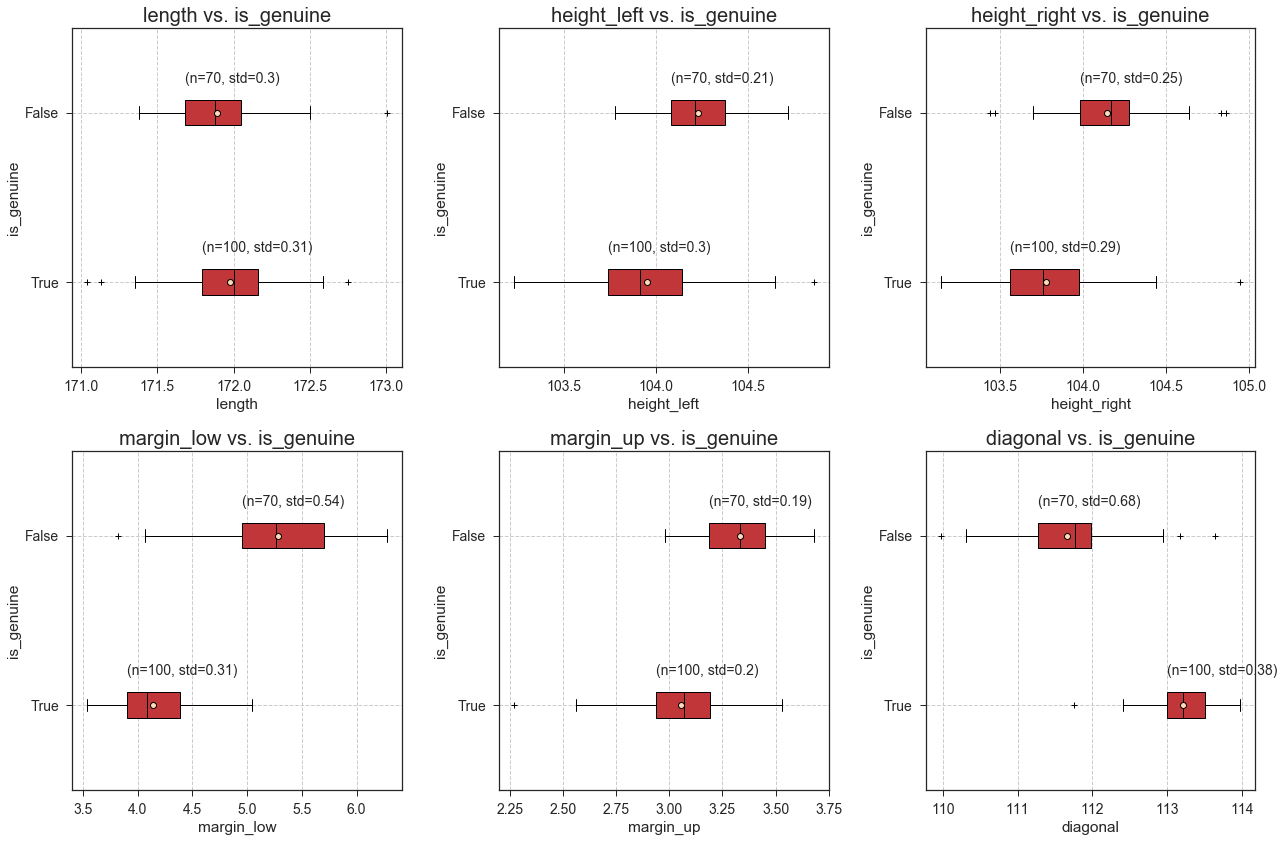

In [11]:
var = data.columns.tolist()
var_qual = var[0]
dic_categ, list_categ = sort_by_categ(data, var_qual)
display_boxplot(dic_categ, list_categ, var_qual, 3)

On constate que :
1. La variable *length* possède des valeurs similaires que les billets soient faux ou vrais
1. Deux variables ont des valeurs nettement différentes en fonction de si les billets sont vrais on non :
    - diagonal
    - margin_low

Pour visualiser la classification qui aura lieu lors de l'analyse exploratoire des données, nous choisirons donc comme plan  celui ou ces deux variables sont le mieux représentées.

<a id=anova_test></a>
#### 2.3.2. Test d'analyse de la variance

Faisons l'hypothèse $\mathcal{H_{0}}$ que *is_genuine* n'est pas corrélées aux caractéristiques géométriques et testons cette hypothèse.

On va commencer par afficher les degrés de libertés et la Somme des Carrés :
- **variation totale** :
    - degrés de liberté : $n - 1$ (avec $n$ le nombre d'individus)
    - SCT : $\sum\limits_{i=1}^{p}\sum\limits_{j=1}^{n_{i}} (y_{ij}-\bar{y})^{2}$
- **variation interclasse** :
    - degrés de liberté : $p - 1$ (avec $p$ le nombre de modalités)
    - SCM : $\sum\limits_{i=1}^{p} n_{i}\times(\bar{y_{i}}-\bar{y})^{2}$
- **variation intraclasse** :
    - degrés de liberté : $n - p$
    - SCR : $\sum\limits_{i=1}^{p}\sum\limits_{j=1}^{n_{i}} (y_{ij}-\bar{y_{i}})^{2}$

In [12]:
var_qual = data.columns[0]
features = data.columns[1:].tolist()
df_anova = anova_sum_squares(data, var_qual, features)

,DL,length,height_left,height_right,margin_low,margin_up,diagonal
variation totale,169,15.800541,15.026539,18.513598,83.308238,9.441471,144.428071
variation interclasse,1,0.306264,3.203577,5.627052,53.332036,3.206859,98.478391
variation intraclasse,168,15.494278,11.822962,12.886546,29.976202,6.234612,45.949680


Nous allons maintenant effectuer les tests statistiques en calculant pour chaque variable :
1. $\eta^{2} = \frac{SCM}{SCT}$
2. $F_{calc} = \frac{SCM/(p-1)}{SCR/(n-p)} \sim\mathcal{F}(p-1, n-p)$
3. $p_{value}$

Si $p_{value}$ est inférieur à 1% alors on pourra rejeter $\mathcal{H_{0}}$, i.e. conclure qu'il y a corrélation.

In [13]:
anova_Ftest(df_anova)

,length,height_left,height_right,margin_low,margin_up,diagonal
eta_2,0.019383,2.131946e-01,3.039415e-01,6.401772e-01,3.396567e-01,6.818508e-01
F,3.320728,4.552166e+01,7.335904e+01,2.988965e+02,8.641312e+01,3.600541e+02
p,0.070190,2.334200e-10,6.665246e-15,3.940145e-39,7.567386e-17,1.234823e-43


Le test confirme notre analyse visuelle :
- Seule la variable *length* n'est pas corrélée à *is_genuine* (p-valeur > 0.01)
- Les 2 variables les plus corrélées à *is_genuine* sont :
    - *margin_low*
    - *diagonal*

<a id=correl></a>
### 2.4. Analyse des corrélations entre les variables quantitatives

Analyse des corrélations linéaires

In [14]:
correl = np.corrcoef(X, rowvar=False)
df_correl = pd.DataFrame(correl)
features = data.columns[1:]
df_correl.index = features
df_correl.columns = features
df_correl

,length,height_left,height_right,margin_low,margin_up,diagonal
length,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
diagonal,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


Comme on pouvait s'en douter, on remarque que :
- La hauteur à droite est fortement corrélée à la hauteur à gauche ;
- Les marges et les hauteurs sont plutôt bien corrélées.

En revanche on peut aussi constater que :
- La diagonale n'est pas corrélée à la longueur ;
- Les marges et les diagonales sont inversement corrélées.

[Retourner à la table des matières](#ToC)

<a id=section3></a>
## 3. Analyse exploratoire de données

Le but de notre analyse est de déterminer si, connaissant certaines de ses caractéristiques géométriques, un billet est faux ou non.
Il va donc falloir chercher ce qui différencie les vrais billets des faux. Pour se faire on va effectuer une analyse multivariée qui va nous permettre d'établir des profils d'individus.

<a id=ACP></a>
### 3.1. Réalisation d'une ACP

Une des techniques d'exploration de données les plus utilisées est la méthode d'Analyse en Composantes Principales (ACP). Elle permet d'étudier :
- La variabilité des individus, i.e. visualiser les individus qui se ressemblent et ceux qui, au contraire, sont éloignés
- De créer des variables synthétiques &ndash; qui seront des combinaisons linéaires des variables initiales &ndash; permettant une meilleure représentation des individus.

Notre jeu de données possédant 170 individus et 6 variables, nous commencerons donc par réaliser une ACP à 6 composantes. Nombre de composantes que nous tenterons de réduire après l'analyse de l'éboulis des valeurs propres.

In [15]:
pca = PCA(n_components=6)

Un ACP devant être réalisée sur des données centrées, nous utiliserons la matrice X_scaled.

In [16]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<a id=eboulis></a>
#### 3.1.1. Analyse de l'éboulis des valeurs propres

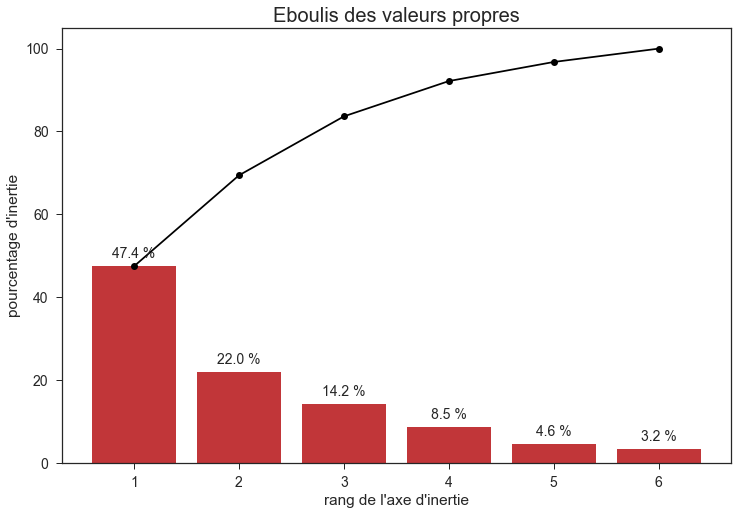

In [17]:
display_scree_plot(pca)

Pour choisir le nombre de composantes principales, il existe plusieurs méthodes, on pourra citer :
- Le nombre de composantes qui explique un pourcentage d'inertie que l'on s'est initialement fixé, par ex. 90% ;
- La méthode du coude, qui consiste à repérer visuellement où le graphique forme un coude, i.e. l'endroit à partir duquel ajouter une nouvelle composante apporte peu d'informations additionnelles ;
- Le critère de Kaiser, on ne garde que les composantes qui explique $\frac{100}{p}$% de l'inertie, p étant le nombre de variables initiales.

Ici nous utiliserons la première en faisant le choix de conserver au moins **90 % de l'inertie**, nous utiliserons donc **4** composantes.

In [18]:
pca = PCA(n_components=4)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

<a id=cercle_correl></a>
#### 3.1.2. Représentation des variables par le cercle des corrélations

Après avoir déterminé le nombre de composantes principales on va maintenant caractériser ces composantes à l'aides du cercle des corrélations dans les différents plans factoriels.

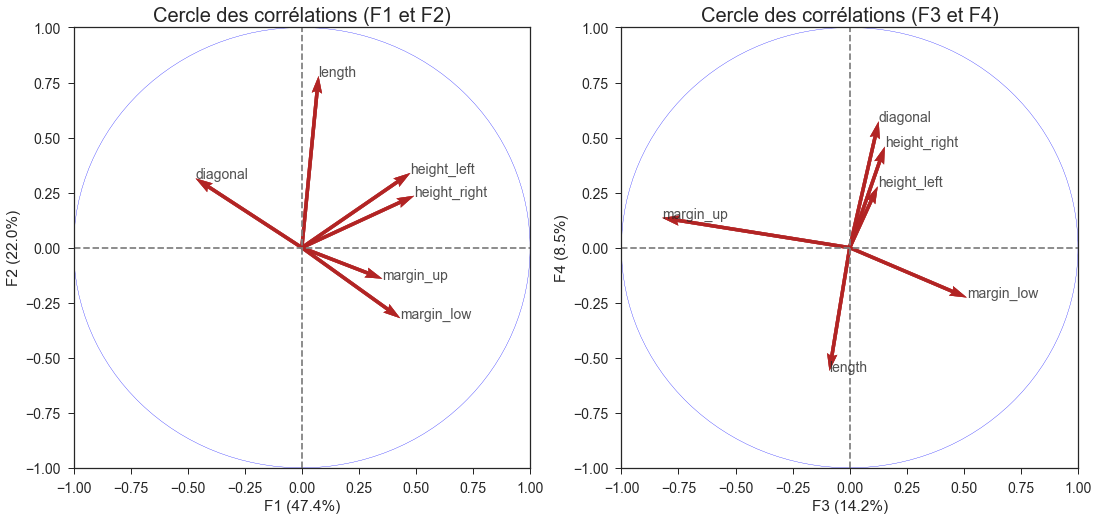

In [19]:
features = data.columns[1:].tolist()
display_circles(pca, features, 2)

- L'axe F1 mesure la hauteur des billets. Comme nous l'avons vu précédemment, les marges et la diagonale étant fortement corrélées (inversement pour la diagonale) aux hauteurs, elles sont aussi relativement bien représentées sur cet axe. Or, comme nous l'avons vu au [2.3](#ANOVA), les faux billets sont caractérisés par une marge inférieure élevée et une diagonale faible, on s'attend donc à visualiser les **faux billets dans la moitié droite du premier plan factoriel**.
- L'axe F2 mesure la longueur des billets. La longueur ne permettant pas de distinguer les vrais billets des faux, cet axe devrait être de faible importance pour la distinction des groupes.
- L'axe F3 mesure la différence entre la marge inférieure et la marge supérieure. Les faux billets étant caractérisés par de forte marges, mesurer leur différence ne va pas être d'une grande aide.
- L'axe F4 semble mesurer le ratio hauteur versus longueur. Bien que la diagonale soit relativement bien présentée, son impact est réduit du fait de sa corrélation inverse avec les hauteurs. Là encore cet axe ne devrait pas être déterminant pour la classification.

Le premier plan factoriel devrait permettre une bonne visualisation des groupe grâce à l'axe F1, en revanche on s'attend à avoir du mal à distinguer les vrais billets des faux dans le 2ème plan factoriel. Projetons les individus dans les plans factoriels pour vérifier notre hypothèse.

<a id=plans_fact></a>
#### 3.1.3. Représentation des individus par les plans factoriels

Ayant caractérisé les composantes principales, il est temps de représenter les individus dans les différents plans factoriels. 

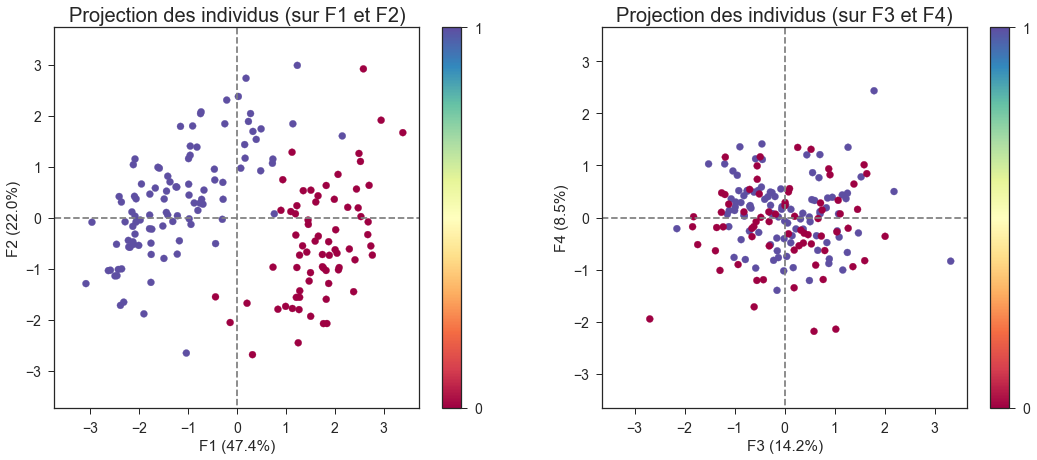

In [20]:
name = data.columns[0]
display_factorial_planes(data, X_scaled, pca, 2, name, True)

On constate que :
- Sur le 1er plan factoriel on distingue relativement bien les groupes, les faux billets étant bien regroupés à droite du graphe.
- sur le 2ème plan factoriel, les individus prennent la forme d'un cercle centré sur l'origine. Comme nous l'avions prévu, il n'y a pas de distinction entre les vrais billets et les faux.

Lors de notre classification nous nous restreindrons donc au 1er plan factoriel pour la visualisation.

<a id=cos2></a>
#### 3.1.4. Qualité de représentation des individus

Pour calculer la qualité de représentation des individus sur les axes, il est d'abord nécessaire de calculer l'inertie de tous ces individus. Comme une ACP est réalisée sur des données centrées, le centre de gravité est l'origine, et donc calculer l'inertie correspond à calculer les carrés des distances à l'origine des individus.
$$d_{i}^{2} = \sum_{j=1}^{p} x_{ij}^{2}$$

In [21]:
# On utilise la matrice contenant les données normalisées
di2 = np.sum(X_scaled**2, axis=1)

On peut maintenant déduire la qualité de représentation de l'individu i sur la composante k à l'aide du cos<sup>2</sup> :

$$cos_{ik}^{2} = \frac{F_{ik}^{2}}{d_{i}^{2}}$$
$F_{ik}^{2}$ étant l'inertie de la projection de l'individu i sur l'axe k, on la récupère via la matrice contenant les coordonnées des projection, i.e. *X_projected*.

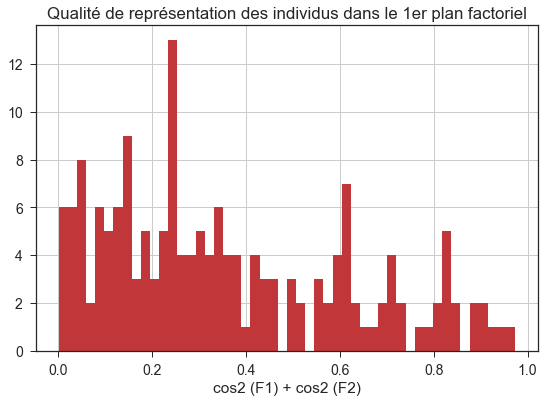

Il y a 28.2 % des billets qui ont une qualité de représentation supérieure ou égale à 0.5


In [22]:
fi2 = X_projected**2
cos2 = np.zeros(X_projected.shape)
for j in range(4): # L'ACP réalisée est à 4 composantes
    cos2[:, j] = fi2[:, j]/di2

# On affiche les résultats pour le premier plan factoriel
df_cos2 = pd.DataFrame({'cos2_F1': cos2[:, 1], 'cos2_F2': cos2[:, 2]})
df_cos2['Total'] = df_cos2['cos2_F1'] + df_cos2['cos2_F2'] 
plt.figure(figsize=(9,6))
df_cos2['Total'].hist(bins=50)
plt.xlabel("cos2 (F1) + cos2 (F2)")
plt.title("Qualité de représentation des individus dans le 1er plan factoriel")
plt.savefig("representation_quality.png")
plt.show()

# On affiche le nombre d'individus ayant une qualité de représentation supérieure à 0.5
n_good = df_cos2[df_cos2['Total']>=0.5].shape[0]
n = df_cos2.shape[0]
print("Il y a {} % des billets qui ont une qualité de représentation\
 supérieure ou égale à 0.5".format(round(n_good/n*100, 1)))                                

On peut voir qu'une majorité (72 %) des individus sont assez mal représentés dans le premier plan factoriel, et donc les distance fortement déformées. Pour éviter ce problème, visualisons dans le 1er plan factoriel uniquement les individus bien représentés.

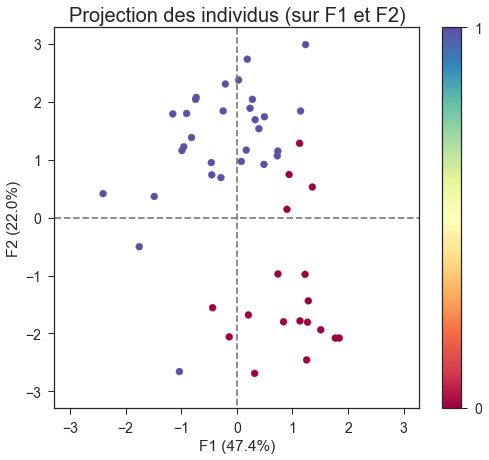

In [23]:
list_ind = df_cos2[df_cos2['Total']>=0.5].index.tolist()
data_2 = data.loc[list_ind, :]
name = data.columns[0]
X_scaled_2= X_scaled[list_ind, :]
pca_2 = PCA(n_components=2)
pca_2.fit(X_scaled)
display_factorial_planes(data_2, X_scaled_2, pca_2, 2, name)

Nous retrouvons nos deux groupes, en revanche la 2ème composante principale - celle rattachée à la longueur - semble être bien plus discriminante pour ces individus.

<a id=CTR></a>
#### 3.1.5. Contribution des individus aux axes

On va regarder maintenant quels sont les individus qui pèsent le plus dans la définition de chaque composante principale.

$$CTR_{ik} = \frac{F_{ik}^{2}}{n\times\lambda_{k}}$$
Avec :
1. $F_{ik}^{2}$ :  l'inertie de la projection de l'individu i sur l'axe k
2. $n$ : le nombre d'individus
3. $\lambda_{k}$ : les variances (valeurs propres) associés aux axes

In [24]:
ctr = X_projected**2
for j in range(4):
        ctr[:, j] = ctr[:, j]/(X_projected.shape[0]*pca.explained_variance_[j])
for i in range(4):
    print("La contribution maximale sur l'axe F{} est {}".format(i+1, round(ctr.max(axis=0)[i], 3)))

La contribution maximale sur l'axe F1 est 0.024
La contribution maximale sur l'axe F2 est 0.04
La contribution maximale sur l'axe F3 est 0.075
La contribution maximale sur l'axe F4 est 0.068


La contribution de chaque individu reste relativement faible.

<a id=kmeans></a>
### 3.2. Classification via la méthode du k-means

Pour réaliser une classification, les deux algorithmes les plus utilisés sont :
- **Le k-means** : crée le nombre de groupes imposé en minimisant l'inertie intraclasse. Convergeant très rapidement, il est très efficace pour les grands jeux de données. Son manque de flexibilité dans le choix du nombre de groupe est son défaut majeur.
- **La classification hiérarchique** : permet de partitionner un jeu de données de manière hiérarchique en agrégeant à chaque étape les deux clusters les plus proches. Contrairement au k-means, il ne nécessite pas de déterminer un nombre de classes au préalable ; il offre donc une plus grande flexibilité quant au choix du nombre de groupes désirés. En revanche, sa forte complexité algorithmique (nécessite beaucoup de temps et d'espace mémoire) fait qu'il sera privilégié pour les petits jeux de données.

Bien que notre jeu de données soit relativement faible (170 individus et 6 variables) nous utiliserons la méthode du k-means. La raison à celà est que nous voulons imposer un nombre de classes à notre algorithme de classification. En effet, l'objectif de notre étude étant de savoir si un billet est vrai ou pas, nous souhaitons avoir deux groupes : l'un contenant les faux billets et l'autre les vrais.

<a id=kmeans_app></a>
#### 3.2.1. Application du k-means

In [25]:
# Application du k-means sur les données normalisées
cls = cluster.KMeans(n_clusters=2, init='k-means++')
cls.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

L'initialisation des clusters s'est faite en utilisant la méthode k-means++. Cette méthode crée les centroïdes initiaux en les choisissants parmi les données de sorte à les éparpiller le plus possible (permet de mitiger l'approche heuristique de l'algorithme).

In [26]:
# On crée une table avec la variable is_genuine et les groupes issus du k-means
data_c = data.copy()
data_c["Clusters"] = cls.labels_
data_c = data_c.iloc[:, [0, -1]]

# On regarde quel groupe est attribué aux vrais billets
eff = data_c[data_c["is_genuine"]==True]["Clusters"].value_counts()
true = eff.index[0]
false = eff.index[1]
print("L'algorithme a assigné :\n- les vrais billets au groupe [{}] et,\n- \
les faux billets au groupe [{}]".format(true, false))

# On crée une colonne test qui va repérer les individus mal classés
data_c["Test"] = data_c["is_genuine"] + data_c["Clusters"]
if true==0:
    n_misclas = data_c[data_c["Test"]!=1].shape[0]
    list_misclas = data_c[data_c["Test"]!=1].index.tolist()
    # On intervertit les groupes par souci de cohérence
    data_c["Clusters"] -= 1
    data_c["Clusters"] = data_c["Clusters"].abs()
else:
    n_misclas = data_c[data_c["Test"]==1].shape[0]
    list_misclas = data_c[data_c["Test"]==1].index.tolist()

# On affiche le nombre d'individus mal classés
percent = round(n_misclas / data_c.shape[0] * 100,1)
print("Il y a {} ({}%) individus mal classés". format(n_misclas, percent))

L'algorithme a assigné :
- les vrais billets au groupe [0] et,
- les faux billets au groupe [1]
Il y a 9 (5.3%) individus mal classés


Regardons quels sont les individus mal classés

In [27]:
data.loc[list_misclas, :]

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,True,171.81,104.86,104.95,4.52,2.89,112.83
5,True,172.57,104.65,104.44,4.54,2.99,113.16
9,True,172.14,104.34,104.20,4.63,3.02,112.47
10,True,172.27,104.29,104.22,3.89,3.53,113.50
65,True,172.16,104.43,104.06,4.51,3.19,112.69
69,True,171.94,104.11,104.16,4.08,3.35,111.76
84,True,172.30,104.58,104.17,4.36,3.33,112.98
96,True,172.00,104.32,104.26,4.53,3.04,112.93
144,False,171.56,103.80,103.87,5.66,2.98,112.95


On constate que la majorité des individus mal classés sont de vrais billets qui ont été qualifiés de faux, ce qui est moins problématique que si ça avait été l'inverse.

<a id=kmeans_vis></a>
#### 3.2.2. Visualisation des groupes

Pour visualiser les groupes, nous allons les projeter dans le premier plan factoriel de l'ACP. Les centroïdes seront représentés par des carrés noirs. Nous afficherons aussi les individus bien classés et ceux mal classés 

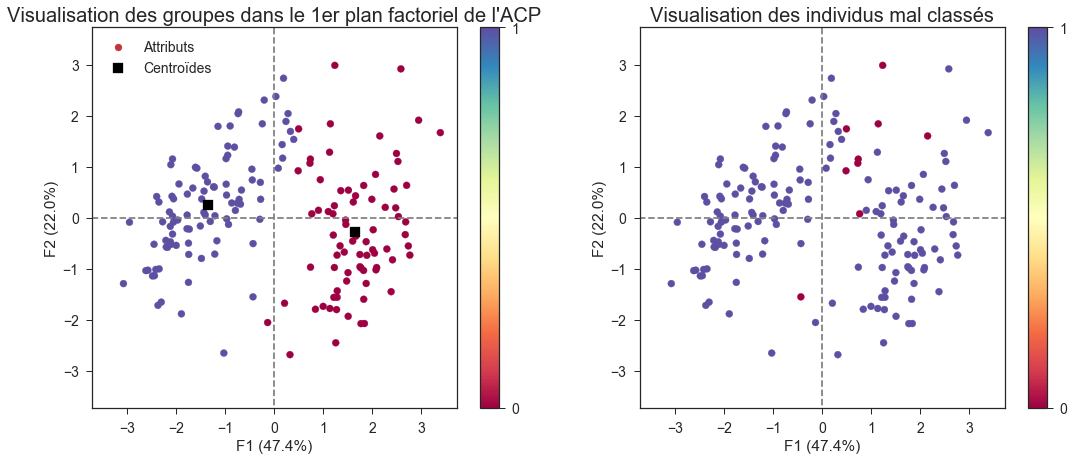

In [28]:
clusters = data_c['Clusters']
data_c["Bien Classé"] = True
data_c.loc[list_misclas, "Bien Classé"] = False
labels = data_c["Bien Classé"]
display_clusters(X_scaled, pca, cls, clusters, labels)

On constate que seuls 5% des individus ont mal été classés, on en déduit que les variables utilisés pour la classification sont suffisantes pour prédire si un billet est faux ou non. Nous utiliserons donc les mêmes variables pour la modélisation.

[Retourner à la table des matières](#ToC)

<a id=section4></a>
## 4. Modélisation

L'objectif de notre modèle est de prédire, à partir de ses caractéristiques géométriques, si un billet est un faux ou pas. Pour cela nous disposons d'un jeu de données déja étiqueté. Il s'agit donc d'un problème de **classification supervisée** qui retourne des valeurs binaires &ndash; 1 pour vrai et 0 pour faux &ndash; ou, dit autrement, d'une classification binaire.

Pour ce type de problème, les deux algorithmes les plus utilisés sont :
- **La régression logistique** : il s'agit en fait d'une régression linéaire sur laquelle on va appliquer un fonction logistique. Bien qu'elle soit basée sur la régression linéaire elle est utilisée pour les problèmes de classification.

$$Logistic(u) = \left( \frac{1}{1+e^{-u}}\right)$$
- **SVM** (Support Vector Machine) : Cette technique va chercher à trouver l'hyperplan qui sépare au mieux les deux classes. Par au mieux, on entend un hyperplan de marge maximale, la marge étant délimitée par les points les plus proches de chaque classe. Contrairement à la régression logistique, la SVM ne va pas renvoyer directement la probabilité mais un score. Ce qui rend son interprétation plus difficile.

<a id=sampling></a>
### 4.1. Échantillonnage

Notre jeu de données ne comportant que 170 individus, il n'est pas nécessaire de l'échantillonner pour réduire le nombre d'individus. Nous utiliserons donc la totalité du jeu de données.

En revanche, avant d'entrainer un algorithme d'apprentissage, il est toujours nécessaire de séparer au préalable notre jeu de données en deux parties distinctes:
- Le **training set**, qui va permettre d'entrainer l'algorithme ;
- Le **testing set**, qui va permettre de tester le modèle sur des données qu'il n'a jamais vues.

Pour ce faire, la méthode `train_test_split()` du module model_selection de scikitlearn sera utilisé. On prendra un échantillon de test correspondant à 25% des données.

In [29]:
y = data.iloc[:, 0].values
y = np.where(y == True, 1, 0)
# On utilise 25% des données dans le jeu de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.25)

<a id=logistic_reg></a>
### 4.2. Régression Logistique

Nous allons commencer par tester la régression logistique, pour cela nous utiliserons la méthode `LogisticRegression()` du module linear_model de scikitlearn.

<a id=lr_withought></a>
#### 4.2.1. Régression logistique sans régularisation

In [30]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

# On récupère la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test)[:,1]

Observons les résultats de notre modèle à l'aide d'une **courbe ROC** (de l'anglais *Receiver Operating Characteristic*) qui permet de mesurer la performance d'un **classifieur binaire** en comparant le nombre de vrais et faux positifs.

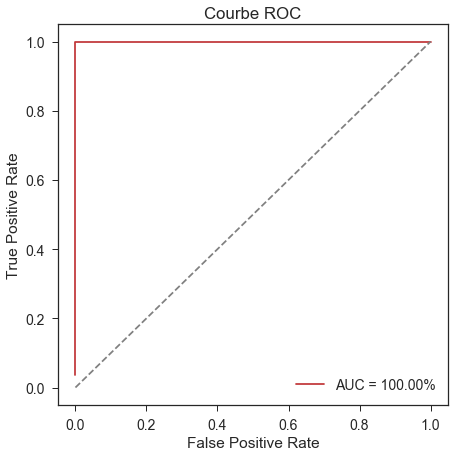

In [31]:
my_roc_curve(y_test, y_prob)

On peut voir que notre classifieur fonctionne très bien. Cependant, la régression logistique étant basée sur la régression linéaire elle souffre des mêmes inconvénients :
1. Quand les variables **sont corrélées**, la solution n'est pas unique et les coefficients ont une grande variabilité &ndash; ce qui rend l'interprétation plus difficile.
2. Si le nombre de variables est plus grand que celui des observations alors la matrice $X^\top X$ n'est pas inversible, empêchant l'unicité de la solution.

Dans notre cas, il y a bien plus d'observations que de variables. En revanche, nous avons vu que certaines variables étaient fortement corrélées &ndash; par exemple les hauteurs à droite et à gauche. Il y a donc un risque de **sur-apprentissage**, i.e. que le modèle colle trop aux données d'entraînement. Pour limiter ce risque, on peut utiliser ce qu'on appelle la technique de **régularisation**. Cette technique consiste à contrôler simultanément l'erreur du modèle sur le jeu d'entrainement et la **complexité du modèle**. Comme plus un modèle est complexe plus le risque de sur-apprentissage est élevé, limiter la complexité du modèle revient à limiter le risque de sur-apprentissage. Ainsi, nous ne chercherons plus à minimiser seulement la somme des carrés des erreurs &ndash; **méthode des moindres carrés** &ndash; mais, à minimiser cette somme plus un terme mesurant la complexité :
$$min_{\beta \in \mathbb{R}^{p+1}}\left((y-X\beta)^\top (y-X\beta) + \lambda \times Regularisateur(\beta) \right)$$
- Le coefficient de **régularisation** $\lambda$, est un **hyperparamètre** toujours **positif** qui contrôle l'importance relative du terme d'erreur et du terme de régularisation. S'il est égale à 0, celà revient à faire une régularisation logistique classique &ndash; non régulariseé.
- Le **Régularisateur**, qui mesure la complexité du modèle, est une fonction des poids $\beta$ du modèle. Les plus utilisés sont :
    - La norme $\ell_2$ ou **norme euclidienne** (**régression ridge**) qui permet de restraindre l'amplitude des poids et d'avoir des coefficients similaires pour les variables corrélées.
    - La norme $\ell_1$ (**méthode du lasso** &ndash; Least Absolute Shrinkage and Selection Operator) qui permet d'avoir un modèle **parcimonieux**, i.e. un modèle avec des coefficients nulles pour les variables non significatives.

<a id=cross_validation></a>
#### 4.2.2. Régression logistique avec régularisation

On appelle **hyperparamètre** tout paramètre qui ne va pas être trouvé par l'algorithme d'apprentissage mais imposé par l'utilisateur. Pour trouver l'hyperparamètre optimal nous effectuerons une **validation croisée** sur le training set. Cette technique permet d'utiliser l'intégralité du jeu d'entrainement, donc sans avoir à en préserver une partie dédiée à la validation du modèle. 
Pour ce faire, nous allons découper le jeu d'entrainement en k parties à peu près égales. Tour à tour, chacune des k parties est utilisée comme jeu de validation ; le reste &ndash; les k-1 autres parties &ndash; est utilisé pour l'entraînement.

Attention, la validation croisée doit être effectuée sur le jeu d'entrainement **seulement** et non sur la totalité du dataset. En effet dans le cas contraire, nous utiliserions les données de test pour choisir le modèle...Il y aurait alors un risque de sur-apprentissage.

Pour effectuer la validation croisée nous utiliserons la méthode `model_selection.GridSearchCV()` de Scikit-Learn. Cette méthode prend en paramètres l'algorithme utilisé mais aussi un dictionnaire ayant pour clés les différents paramètres de l'algorithme que nous voulons tester. Ici, l'algorithme que nous voulons tester est la régression logistique &ndash; `LogisticRegression()` &ndash; et, vu que nous souhaitons trouver la régularisation optimale, allons pouvoir jouer sur 2 paramètres :
- "C" : il s'agit de l'inverse du coefficient de régularisation, i.e. $\frac{1}{\lambda}$
- "penalty" : il s'agit du régularisateur que nous souhaitons tester, nous utiliserons $\ell_1$ et $\ell_2$

In [32]:
params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2'] }

lr_cv = model_selection.GridSearchCV(lr, params, cv=10) # on découpe en 10 parties
lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_) # On affiche la meilleure régularisation

{'C': 0.1, 'penalty': 'l1'}


On peut voir que la meilleure régularisation est obtenue en utilisant **le régularisateur $\ell_1$ avec un coefficient de régularisation $\lambda$ égal à 1** (C = $\frac{1}{\lambda}$ = 1).

Observons maintenant la performance du modèle.

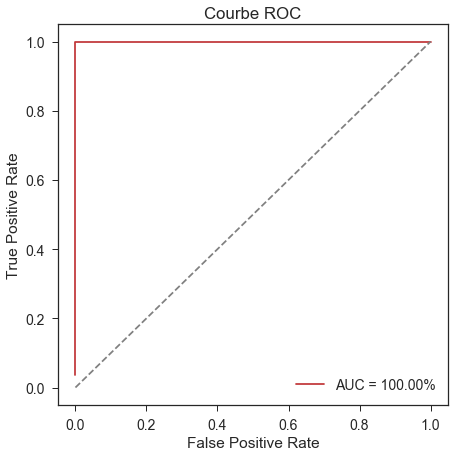

In [33]:
# On récupère la prédiction de la valeur positive
y_prob = lr_cv.predict_proba(X_test)[:,1] 


# On affiche la courbe ROC
my_roc_curve(y_test, y_prob)

Sans surprise, là encore notre classifieur fonctionne parfaitement.

<a id=SVM></a>
### 4.3. SVM

Pour réaliser la SVM, nous utiliserons la méthode `LinearSVC()` du module *svm* de Scikit-Learn.

Bien souvent, les données ne sont pas linéairement séparables, autrement dit il ne sera pas possible de trouver un hyperplan qui permet de séparer tous les individus en deux groupes. Il faudra donc accepter de faire des erreurs, i.e. accepter que certains points de notre jeu d'entrainement se retrouvent du mauvais côté de la frontière.

Plus la marge est grande, plus nous sommes susceptibles d'avoir des erreurs. On va donc chercher à maximiser la marge tout en minimisant l'erreur. Ainsi, comme pour la régularisation d'une régression logistique, il va falloir trouver un hyperparamètre C qui va servir à quantifier l'importance relative du terme d'erreur et du terme de marge. Pour mesurer l'erreur (équivalent du régularisateur pour la régression logistique) on utilisera la **perte hinge**.

Pour touver l'hyperparamètre optimal, nous utiliserons là encore une validation croisée.

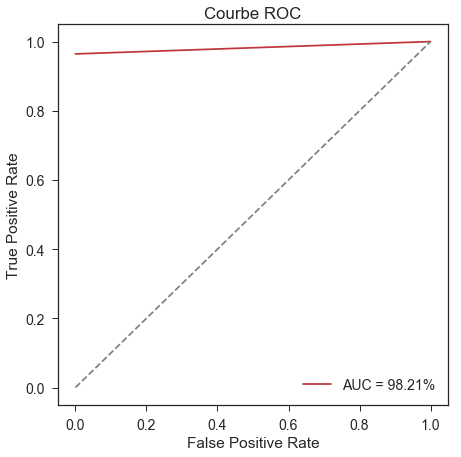

{'C': 0.01}


In [34]:
# On réalise la SVM
svm = LinearSVC()

# On effectue la validation croisée
params = {'C': np.logspace(-3, 3, 7)}
svm_cv = model_selection.GridSearchCV(svm, params, cv=10)
svm_cv.fit(X_train, y_train)

# On récupère la prédiction de la valeur positive
y_prob_svm = svm_cv.predict(X_test)

# On affiche la courbe ROC
my_roc_curve(y_test, y_prob_svm)

print(svm_cv.best_params_) # On affiche le meilleur hyperparamètre

On peut voir qu' avec la SVM, notre classifieur est légèrement moins efficace. Nous utiliserons donc **le modèle basé sur la régression Logistique régularisée pour tester les nouveaux billets.**

[Retourner à la table des matières](#ToC)

<a id=section5></a>
## 5. Tests

In [35]:
test = pd.read_csv("exemple.csv")
test.head()

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5


In [36]:
test_billet(test, std_scale, lr_cv)

Le billet B_1 est faux avec une probabilité de 93.06%
Le billet B_2 est faux avec une probabilité de 96.12%
Le billet B_3 est faux avec une probabilité de 90.17%
Le billet B_4 est vrai avec une probabilité de 78.34%
Le billet B_5 est vrai avec une probabilité de 91.24%


In [37]:
test = pd.read_csv("test_billets_validation_projet.csv")
test.head()

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [38]:
test_billet(test, std_scale, lr_cv)

Le billet B_1 est vrai avec une probabilité de 77.66%
Le billet B_2 est faux avec une probabilité de 87.81%
Le billet B_3 est vrai avec une probabilité de 89.94%
Le billet B_4 est faux avec une probabilité de 97.30%
Le billet B_5 est faux avec une probabilité de 78.25%
